In [151]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%run tests.py

class Orbits():
    def __init__(self,label, mother=False):
        self.name = label
        self.daughters = []
        self.mother = mother
        if mother:
            mother.add_daughter(self)
    
    def get_name(self):
        return self.name
    
    def add_daughter(self,daughter):
        self.daughters.append(daughter)
        
    def add_mother(self, mother):
        self.mother=mother

    def __repr__(self):
        if not self.mother:
            stringrep = "*"
        else:
            stringrep = ""
        if len(self.daughters)==0:
            return stringrep+"Name = {}".format(self.name)
        else:
            stringrep += "Name = {}, daughters = [".format(self.name)
            for d in self.daughters:
                stringrep += "{},".format(d)
            stringrep+=("]")
            return stringrep
    
    
    def get_moms_name(self):
        if self.mother:
            return self.mother.get_name()
        else:
            return "root"
    
    def get_self(self,name):
        if name ==self.name:
            return self
        else:
            return None
        
def build_tree(edges):
    roots = set()
    nodenames = list()
    for edge in edges:
        mother, child = edge.split(")")
        if not mother in nodenames:
            newroot = (Orbits(mother))
            roots.add(newroot)
            nodenames.append(mother)
        for root in roots:
            existingmom = find_node(root,mother)
            if existingmom:
                break 
        if not child in nodenames:
            newkid = Orbits(child,mother=existingmom)
            nodenames.append(child)
            continue
        else:
            for root in roots:
                existingkid = find_node(root,child)
                if existingkid:
                    break
            existingmom.add_daughter(existingkid)
            existingkid.add_mother(existingmom)
            if existingkid in roots:
                roots.remove(existingkid)
    if len(roots) > 1:
        return "Not valid description"
    else:
        return list(roots)[0]

def find_node(node,name):
    if node.get_self(name):
        return node
    elif len(node.daughters)==0:
        return False
    for d in node.daughters:
        descendant = find_node(d, name)
        if descendant:
            return descendant
    return False

        

def get_height(node, height):
    if not node.mother:
        return height
    else:
        return get_height(node.mother, height+1)

def get_daughter_heights(node, heightdict):
    heightdict[node.get_name()]=get_height(node,0)
    if len(node.daughters)>0:
        for d in node.daughters:
            heightdict.update(get_daughter_heights(d,heightdict))
    return heightdict    

def add_up_all_height(node):
    if isinstance(node,list):
        node = build_tree(node)
    heightdict = get_daughter_heights(node, {})
    return pd.Series(heightdict).sum()

def is_descendant(mom,child):
    if not child.mother:
        return False
    elif child.mother==mom:
        return True
    else:
        return is_descendant(mom,child.mother)
        
def count_steps(mom,child):
    if not is_descendant(mom,child):
        return -1
    if child.mother == mom:
        return 1
    else:
        return 1+count_steps(mom,child.mother)
    
        
def find_common_ancestor(child1, child2):
    if is_descendant(child1,child2):
        return child1
    else:
        return find_common_ancestor(child1.mother,child2)
    return False

def orbital_path(root,you,santa):
    if isinstance(root, list):
        root = build_tree(root)
    you = find_node(root,you)
    santa = find_node(root,santa)
    if not (you and santa):
        return False
    progenitor = find_common_ancestor(you,santa)
    return count_steps(progenitor,you.mother)+count_steps(progenitor,santa.mother)
    

def labels_and_locs(node, momx,momy, myx,myy):
    newx = myx
    newy = myy
    name = node.get_name()
    row = pd.DataFrame({name:{'momx':momx,'momy':momy, 'myx':myx, 'myy':myy}}).T
    if len(node.daughters)==0:
        return row
    elif len(node.daughters)==1:
        return pd.concat([row,labels_and_locs(node.daughters[0],myx,myy,newx,newy+1)], sort=False)
    else:
        a = labels_and_locs(node.daughters[0],myx,myy,newx-2, newy+1)
        b = labels_and_locs(node.daughters[1],myx,myy,newx+2,newy+1)
        return pd.concat([row,a,b], sort=False) 

def draw_nodemap(root, savefig=False):
    if isinstance(root,list):
        root = build_tree(root)
    nodedf = labels_and_locs(root,0,0,0,0)
    minx = np.min([nodedf['momx'].min(),nodedf['myx'].min()])
    maxx = np.max([nodedf['momx'].max(),nodedf['myx'].max()])
    miny = np.min([nodedf['momy'].min(),nodedf['myy'].min()])
    maxy = np.max([nodedf['momy'].max(),nodedf['myy'].max()])
    rangex = maxx-minx
    rangey = maxy-miny
    wh = 10*plt.figaspect(rangey/rangex)
    fig, ax = plt.subplots(figsize=wh)
    for label, row in nodedf.iterrows():
        xs = [row['momx'],row['myx']]
        ys = [row['momy'],row['myy']]
        ax.annotate(label,xy=(row['myx'],row['myy']))
        ax.plot(xs,ys, linestyle=":", color='black')
    if savefig:
        fig.savefig("Santa-Orbital_diagram.png")
    return nodedf
    ax.set_xlim(minx-1,maxx+1)
    ax.set_ylim(miny-1,maxy+1)



In [152]:
ins = ["""COM)B
B)C
C)D
D)E
E)F
B)G
G)H
D)I
E)J
J)K
K)L""".split("\n"),
"""COM)B
B)C
C)D
D)E
E)F
B)G
G)H
D)I
E)J
J)K
K)L
K)YOU
I)SAN""".split("\n"),]
outs = [[42,54],[False,4]]
funcs = [add_up_all_height,orbital_path]
simple_test(funcs[0],ins,outs[0])
multi_param_test(funcs[1], [(i,'YOU','SAN') for i in ins],outs[1])

True

In [53]:
with open("2019_12_6_input.txt") as fileobj:
    raw = fileobj.read()
edges = raw.strip().split("\n")

In [156]:
#Answer
orbital_path(edges,"YOU", "SAN")

424

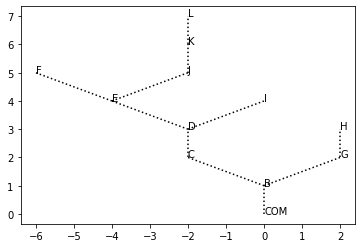

In [139]:
df = draw_nodemap(ins[0])

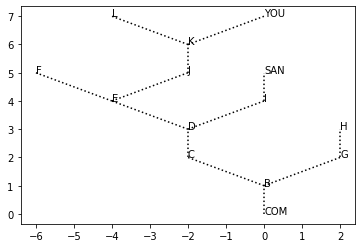

In [140]:
df = draw_nodemap(ins[1])

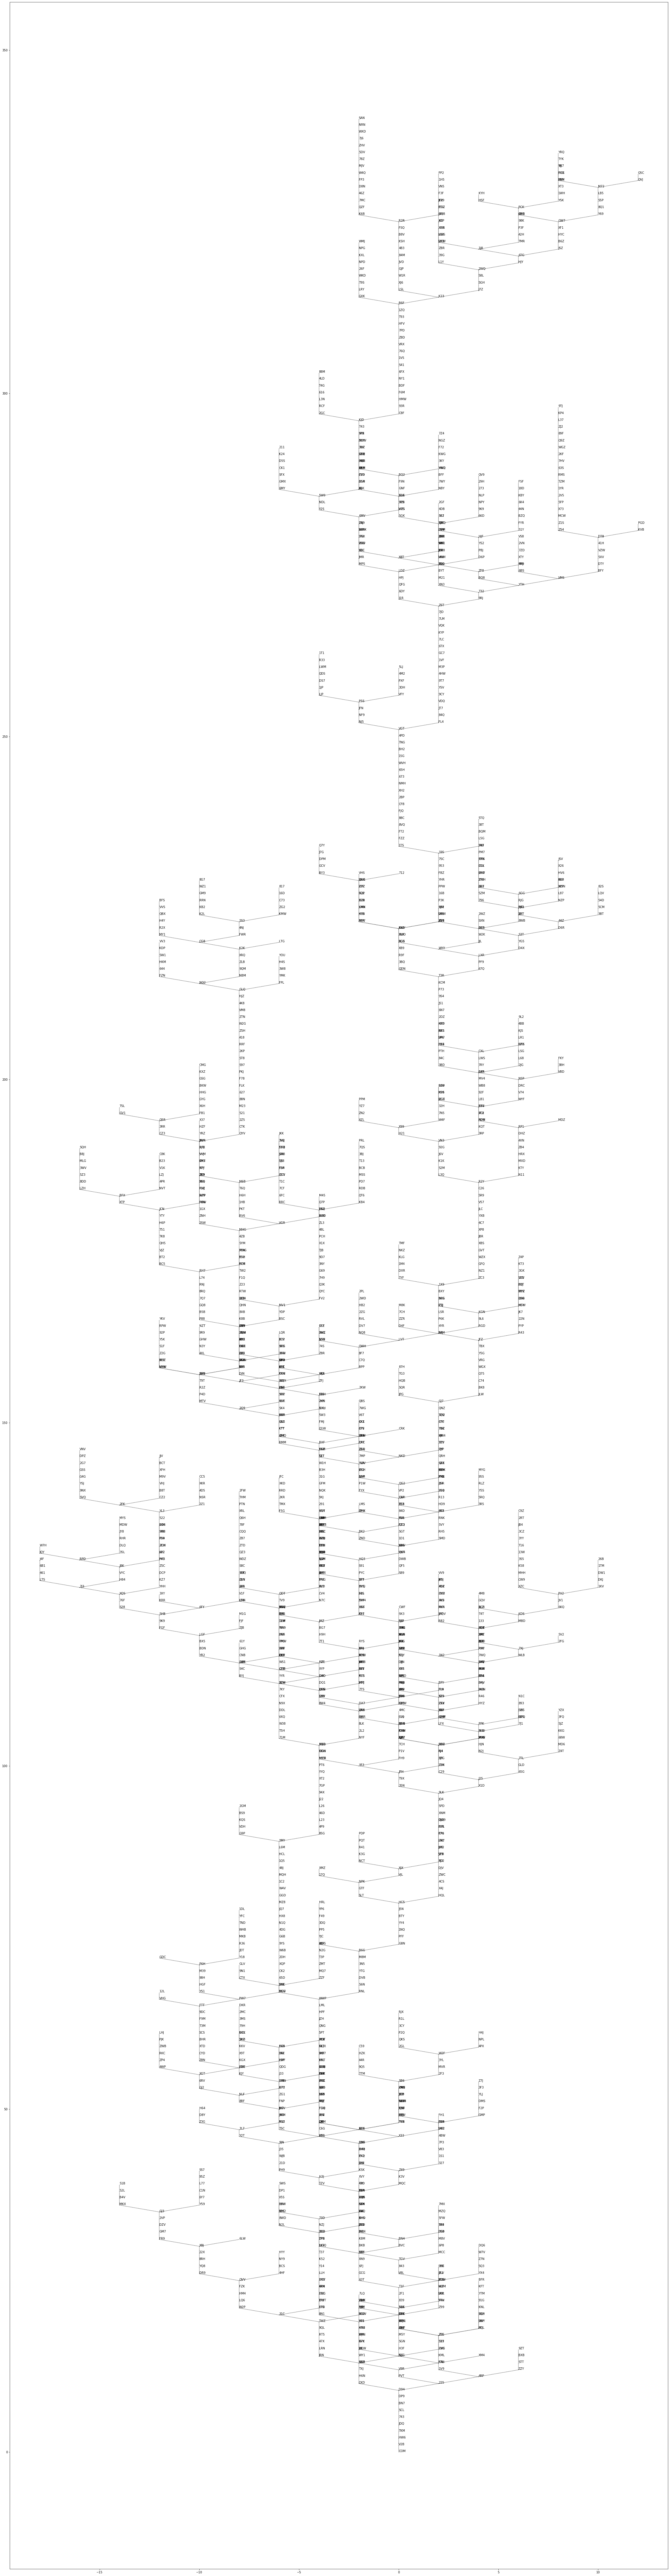

In [150]:
df = draw_nodemap(edges, savefig=True)